In [1]:
# 環境構築

!apt-get update
!apt-get install -y libsndfile1-dev
!pip install scipy
!pip install scikit-learn
!pip install librosa

/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/a

In [2]:
# clips 作成

SAMPLING_RATE = 44100 # 変更不可

clip_size = 81920 # 楽曲を再構築するパーツ1つあたりの大きさ
step_size = 20480 # clip をずらすときの大きさ
window_size = 10240 # CQT_CHROMA を取得するのに使用するサンプル数
hop_size = 640 # window をずらすときの大きさ

from scipy.io.wavfile import read, write
import glob
import os
import numpy as np
import librosa
import sys

if os.path.isfile("../data/out/clips.wav"):
    print("../data/out/clips.wav exists.")
    files = ["../data/out/clips.wav"]
else:
    # clips.npy をもとにデータを作成する 
    if os.path.isfile("../data/arrays/clips.npy"):
        print("loading ../data/arrays/clips.npy ...")
        clips = np.load("../data/arrays/clips.npy")
        print("creating ../data/out/clips.wav ...")
        write("../data/out/clips.wav", SAMPLING_RATE, clips.reshape((clips.shape[0] * clips.shape[1], )))
        files = ["../data/out/clips.wav"]
        
    # clips,npy がないとき /data/wav44100 内の WAV ファイルを参照する
    else:
        files = glob.glob("../data/wav44100/*.wav")
        #files = ["../data/wav44100/3DEmbodimentFromLines.wav"] # デバッグ用 
        
if len(files) == 0:
    print("WAV ファイルが見つかりませんでした。")
    sys.exit(1)
        
clips_filename = "../data/arrays/c" + str(clip_size) + "_s" + str(step_size) + "_f32_clips"

if os.path.isfile(clips_filename + ".npy"):
    print("loading " + clips_filename + ".npy ...")
    clips = np.load(clips_filename + ".npy")
else:
    print("creating " + clips_filename + ".npy ...")
    raw_data_list = [librosa.load(file, sr=SAMPLING_RATE)[0] for file in files] # 左の音だけ使う

    clips = np.zeros((0, clip_size), dtype=np.float32)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, step_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save(clips_filename, clips)

print("The clip array has " + str(clips.shape[0]) + " clips.")

../data/out/clips.wav exists.
loading ../data/arrays/c81920_s20480_f32_clips.npy ...
The clip array has 57148 clips.


In [3]:
# cqt 作成

n_bins = 84

cqt_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqts"

if os.path.isfile(cqt_filename + ".npy"):
    print("loading " + cqt_filename + ".npy ...")
    cqts = np.load(cqt_filename + ".npy")
else:
    print("creating " + cqt_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("cqt progress: clip " + str(num + 1) + " / " + str(len(clips)))
        
        tmp_cqt = librosa.cqt(clip, sr=SAMPLING_RATE, hop_length=hop_size, n_bins=n_bins)
        tmp_cqt = tmp_cqt.reshape((1, tmp_cqt.shape[0], tmp_cqt.shape[1]))
        
        if num == 0:
            cqts = tmp_cqt
        else:
            cqts = np.vstack((cqts, tmp_cqt))
            
        num += 1

    np.save(cqt_filename, cqts)
    
print("The cqt array has " + str(cqts.shape[0]) + " cqts.")
print("cqts.shape: " + str(cqts.shape))
print("Type(cqts[0][0][0]): " + str(type(cqts[0][0][0])))
print("np.max(cqts[0][0]): " + str(np.max(cqts[0][0])))

loading ../data/arrays/c81920_s20480_f32_clips_w10240_h640_cqts.npy ...
The cqt array has 57148 cqts.
cqts.shape: (57148, 84, 129)
Type(cqts[0][0][0]): <class 'numpy.complex64'>
np.max(cqts[0][0]): (0.021538047+0.007131239j)


In [4]:
# cqt_choroma 作成

def Preprocessing(array):
    array = np.abs(array)
    array = np.log(array + 1)
    array = array / np.log(np.finfo(np.float32).max)
    array = array.T
    return array

cqt_chroma_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqt_chromas"

if os.path.isfile(cqt_chroma_filename + ".npy"):
    print("loading " + cqt_chroma_filename + ".npy ...")
    cqt_chromas= np.load(cqt_chroma_filename + ".npy")
else:
    print("creating " + cqt_chroma_filename + ".npy ...")
    num = 0
    for cqt in cqts:
        print("cqt_chroma progress: clip " + str(num + 1) + " / " + str(len(cqts)))
        
        tmp_cqt_chroma = librosa.feature.chroma_cqt(C=cqt, sr=SAMPLING_RATE)
        tmp_cqt_chroma = Preprocessing(tmp_cqt_chroma)
        tmp_cqt_chroma = tmp_cqt_chroma.reshape((1, tmp_cqt_chroma.shape[0], tmp_cqt_chroma.shape[1]))
        
        if num == 0:
            cqt_chromas = tmp_cqt_chroma
        else:
            cqt_chromas = np.vstack((cqt_chromas, tmp_cqt_chroma))
            
        num += 1

    np.save(cqt_chroma_filename, cqt_chromas)
    
print("The cqt_chroma array has " + str(cqt_chromas.shape[0]) + " cqt_chromas.")
print("cqt_chromas.shape: " + str(cqt_chromas.shape)) # clip 番号、window 番号、 chroma 番号 になる
print("Type(cqt_chromas[0][0][0]): " + str(type(cqt_chromas[0][0][0])))
print("np.max(cqt_chromas[0][0]): " + str(np.max(cqt_chromas[0][0])))

loading ../data/arrays/c81920_s20480_f32_clips_w10240_h640_cqt_chromas.npy ...
The cqt_chroma array has 57148 cqt_chromas.
cqt_chromas.shape: (57148, 129, 12)
Type(cqt_chromas[0][0][0]): <class 'numpy.float32'>
np.max(cqt_chromas[0][0]): 0.0078125


In [5]:
# max_norm 作成

num_divide = 8

max_norm_filename = clips_filename + "_d" + str(num_divide) + "_max_norms"

if os.path.isfile(max_norm_filename + ".npy"):
    print("loading " + max_norm_filename + ".npy ...")
    max_norms= np.load(max_norm_filename + ".npy")
else:
    print("creating " + max_norm_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("max_norm progress: clip " + str(num + 1) + " / " + str(len(clips)))
        max_norm = [np.max(clip[int((i / num_divide) * len(clip)):int(((i + 1) / num_divide) * len(clip))] ** 2) for i in range(num_divide)]
    
        if num == 0:
            max_norms = np.array(max_norm)
        else:
            max_norms = np.vstack((max_norms, np.array(max_norm)))
        num += 1
        
    np.save(max_norm_filename, max_norms)
    
print("The max_norm array has " + str(max_norms.shape[0]) + " max_norms.")
print("max_norms.shape: " + str(max_norms.shape))
print("Type(max_norms[0][0]): " + str(type(max_norms[0][0])))
print("np.max(max_norms[0]): " + str(np.max(max_norms[0])))

loading ../data/arrays/c81920_s20480_f32_clips_d8_max_norms.npy ...
The max_norm array has 57148 max_norms.
max_norms.shape: (57148, 8)
Type(max_norms[0][0]): <class 'numpy.float32'>
np.max(max_norms[0]): 0.0179649


In [6]:
# 学習データとテストデータに分ける

def normalize(array):
    if (np.sum(array) == 0):
        return array
    else:
        return array / np.sum(array)
    
cqt_chroma_sum_threshold = 0.01 # 次の window の sum が閾値に満たないときに除外します
test_data_rate = 0.1

window_num_per_clip = cqt_chromas.shape[1]

cqt_chromas = np.array([np.hstack((cqt_chromas[i], np.repeat(np.array([max_norms[i]]), cqt_chromas.shape[1], axis=0))) for i in range(len(max_norms))])
cqt_chromas = np.concatenate([cqt_chromas[:-1, :, :], cqt_chromas[1:, 0, :].reshape(cqt_chromas.shape[0] - 1, 1, cqt_chromas.shape[2])], 1)

p = np.random.permutation(len(cqt_chromas))
cqt_chromas = cqt_chromas[p]
clips = clips[p]

x = np.delete(cqt_chromas, np.where(np.sum(cqt_chromas[:,-1,:], axis=1) < cqt_chroma_sum_threshold)[0], axis=0)

x_test = x[:int(x.shape[0] * test_data_rate), :window_num_per_clip, :].reshape(int(x.shape[0] * test_data_rate), window_num_per_clip, x.shape[2], 1)
x_train = x[int(x.shape[0] * test_data_rate):, :window_num_per_clip, :].reshape(x.shape[0] - int(x.shape[0] * test_data_rate), window_num_per_clip, x.shape[2], 1)

y = np.array([x[:, window_num_per_clip, i] for i in range(x.shape[2])])
y_maxs = np.max(y, axis=1)
y_mins = np.min(y, axis=1)

y_tests =  np.array([(x[:int(x.shape[0] * test_data_rate), window_num_per_clip, i] - y_mins[i]) / (y_maxs[i] - y_mins[i]) for i in range(x.shape[2])])
y_trains = np.array([(x[int(x.shape[0] * test_data_rate):, window_num_per_clip, i] - y_mins[i]) / (y_maxs[i] - y_mins[i]) for i in range(x.shape[2])])

print("x_train.shape: " + str(x_train.shape))
print("x_test.shape: " + str(x_test.shape))
print("y_trains.shape: " + str(y_trains.shape))
print("y_tests.shape: " + str(y_tests.shape))

x_train.shape: (51409, 129, 20, 1)
x_test.shape: (5712, 129, 20, 1)
y_trains.shape: (20, 51409)
y_tests.shape: (20, 5712)


In [7]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [8]:
# モデル作成

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, Input, MaxPooling2D
from keras.optimizers import Adam

learning_rate = 0.001

models = []
for i in range(x.shape[2]):
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3, 1), activation="relu", input_shape=(window_num_per_clip, cqt_chromas.shape[2], 1)))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

    model.build()
    model.summary()
    
    models.append(model)

2023-03-18 00:10:20.655011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 00:10:20.949364: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-18 00:10:23.764433: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/allegro/miniconda3/lib/
2023-03-18 00:10:23.767861: W tensorflow/compiler/xla/st

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 20, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 20, 32)        0         
                                                                 
 flatten (Flatten)           (None, 40320)             0         
                                                                 
 dense (Dense)               (None, 1)                 40321     
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                        

000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-18 00:10:25.498342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-18 00:10:25.498356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-18 00:10:33.264299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-18 00:10:33.265346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been 

 max_pooling2d_1 (MaxPooling  (None, 63, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 63, 20, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 40320)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 40321     
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 40,449
Trainable params: 40,449
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape         

                                                                 
 activation_7 (Activation)   (None, 1)                 0         
                                                                 
Total params: 40,449
Trainable params: 40,449
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 20, 32)        0         
                                                                 
 flatten_8 (Flatten)         (None, 40320)        

 conv2d_14 (Conv2D)          (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 63, 20, 32)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 63, 20, 32)        0         
                                                                 
 flatten_14 (Flatten)        (None, 40320)             0         
                                                                 
 dense_14 (Dense)            (None, 1)                 40321     
                                                                 
 activation_14 (Activation)  (None, 1)                 0         
                                                                 
Total params: 40,449
Trainable params: 40,449
Non-trainable params: 0
_________________________________________________________________
Model:

In [9]:
# 学習
batch_size = 64
epochs = 100

data_name = "c" + str(clip_size) + "_s" + str(step_size) + "_w" + str(window_size) + "_h" + str(hop_size) + "_d" + str(num_divide)

histories = []
for i in range(x.shape[2]):
    model_name = "independent_" + data_name + "_batch" + str(batch_size) + "_e" + str(epochs) + "_" + str(i)

    histories.append(models[i].fit(x_train, y_trains[i],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_tests[i])))

    models[i].save("../data/models/" + model_name)

Epoch 1/100


2023-03-18 00:10:35.799950: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-18 00:10:39.247607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-18 00:10:43.027219: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-18 00:10:43.070013: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-18 00:10:43.070079: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-18 00:10:43.111970: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-18 00:10:43.11

804/804 [==============================] - 18s 7ms/step - loss: 0.6212 - accuracy: 0.5016 - val_loss: 0.6188 - val_accuracy: 0.5037
Epoch 2/100
804/804 [==============================] - 5s 6ms/step - loss: 0.6120 - accuracy: 0.5025 - val_loss: 0.6070 - val_accuracy: 0.5037
Epoch 3/100
804/804 [==============================] - 5s 6ms/step - loss: 0.5961 - accuracy: 0.5039 - val_loss: 0.5868 - val_accuracy: 0.5119
Epoch 4/100
804/804 [==============================] - 5s 6ms/step - loss: 0.5787 - accuracy: 0.5134 - val_loss: 0.5653 - val_accuracy: 0.5226
Epoch 5/100
804/804 [==============================] - 5s 6ms/step - loss: 0.5597 - accuracy: 0.5236 - val_loss: 0.5467 - val_accuracy: 0.5326
Epoch 6/100
804/804 [==============================] - 5s 6ms/step - loss: 0.5418 - accuracy: 0.5300 - val_loss: 0.5308 - val_accuracy: 0.5375
Epoch 7/100
804/804 [==============================] - 5s 6ms/step - loss: 0.5286 - accuracy: 0.5339 - val_loss: 0.5174 - val_accuracy: 0.5417
Epoch 8/10

804/804 [==============================] - 5s 6ms/step - loss: 0.4545 - accuracy: 0.5539 - val_loss: 0.4587 - val_accuracy: 0.5548
Epoch 59/100
804/804 [==============================] - 5s 6ms/step - loss: 0.4546 - accuracy: 0.5537 - val_loss: 0.4590 - val_accuracy: 0.5518
Epoch 60/100
804/804 [==============================] - 5s 6ms/step - loss: 0.4545 - accuracy: 0.5546 - val_loss: 0.4606 - val_accuracy: 0.5537
Epoch 61/100
804/804 [==============================] - 5s 6ms/step - loss: 0.4542 - accuracy: 0.5540 - val_loss: 0.4585 - val_accuracy: 0.5553
Epoch 62/100
804/804 [==============================] - 5s 6ms/step - loss: 0.4552 - accuracy: 0.5534 - val_loss: 0.4596 - val_accuracy: 0.5546
Epoch 63/100
804/804 [==============================] - 5s 6ms/step - loss: 0.4537 - accuracy: 0.5540 - val_loss: 0.4579 - val_accuracy: 0.5557
Epoch 64/100
804/804 [==============================] - 5s 6ms/step - loss: 0.4536 - accuracy: 0.5550 - val_loss: 0.4617 - val_accuracy: 0.5539
Epoch

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e100_0/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e100_0/assets


Epoch 1/100
 11/804 [..............................] - ETA: 9s - loss: 0.6516 - accuracy: 0.4972

2023-03-18 00:19:21.825742: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.6443 - accuracy: 0.4994 - val_loss: 0.6422 - val_accuracy: 0.5023
Epoch 2/100
804/804 [==============================] - 5s 6ms/step - loss: 0.6419 - accuracy: 0.5015 - val_loss: 0.6407 - val_accuracy: 0.5023
Epoch 3/100
804/804 [==============================] - 5s 6ms/step - loss: 0.6393 - accuracy: 0.5015 - val_loss: 0.6395 - val_accuracy: 0.5023
Epoch 4/100
804/804 [==============================] - 5s 6ms/step - loss: 0.6344 - accuracy: 0.5015 - val_loss: 0.6306 - val_accuracy: 0.5023
Epoch 5/100
804/804 [==============================] - 5s 6ms/step - loss: 0.6241 - accuracy: 0.5015 - val_loss: 0.6157 - val_accuracy: 0.5021
Epoch 6/100
804/804 [==============================] - 5s 6ms/step - loss: 0.6085 - accuracy: 0.5010 - val_loss: 0.6128 - val_accuracy: 0.5023
Epoch 7/100
804/804 [==============================] - 5s 6ms/step - loss: 0.5903 - accuracy: 0.4982 - val_loss: 0.5762 - val_accuracy: 0.5014
Epoch 8/100

/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
=== History 0 ===


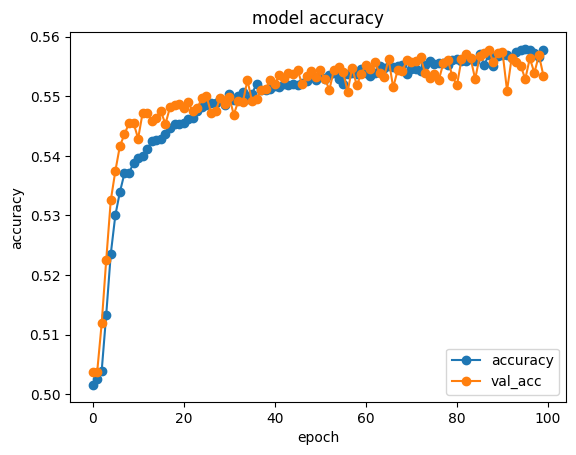

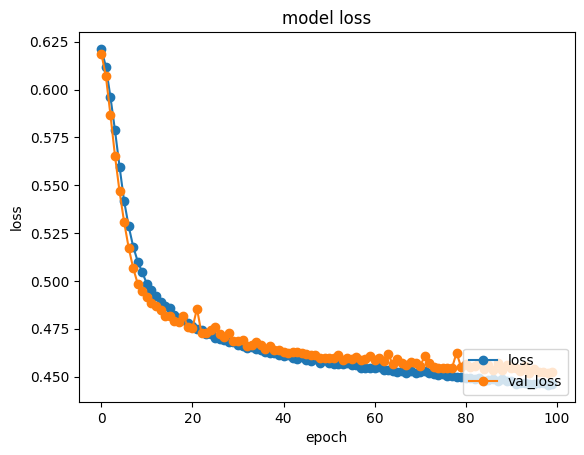

=== History 1 ===


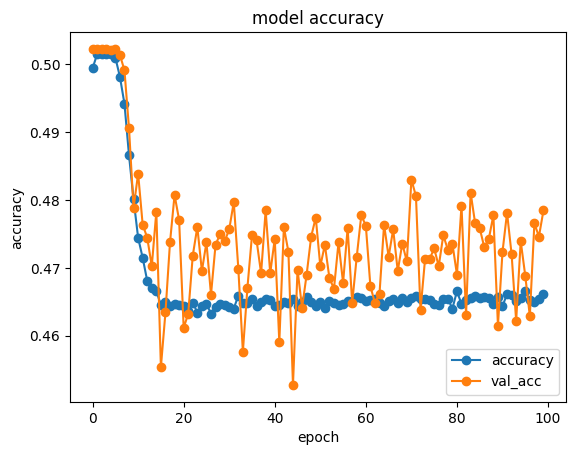

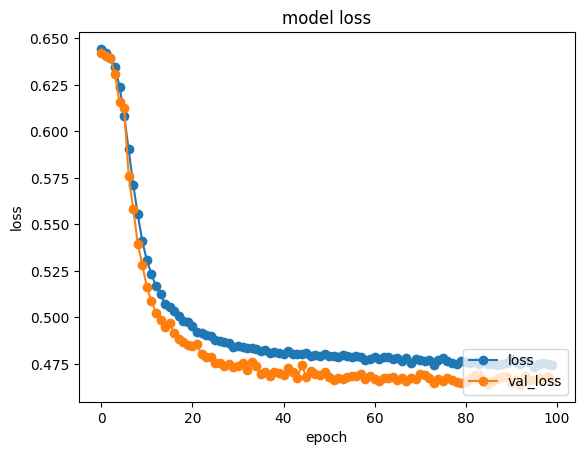

=== History 2 ===


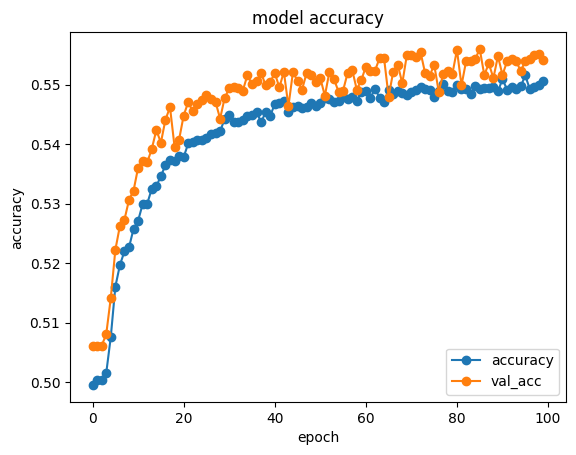

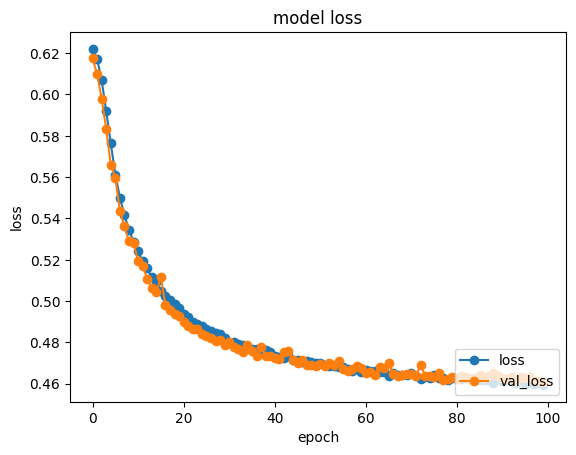

=== History 3 ===


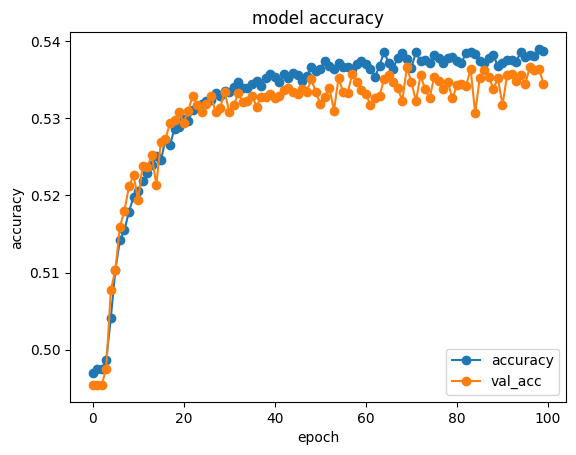

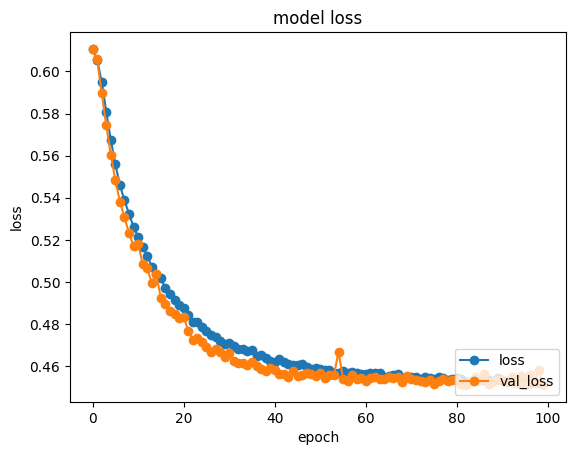

=== History 4 ===


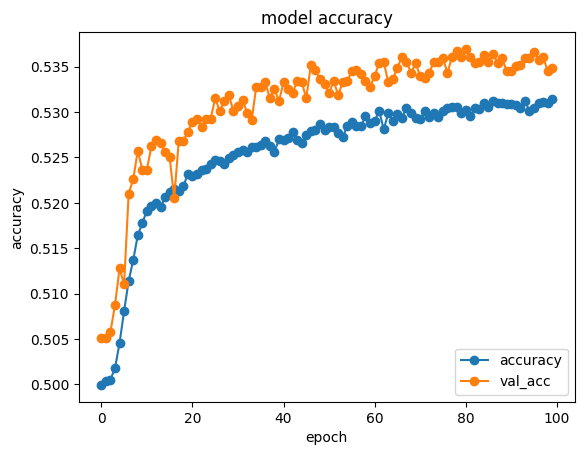

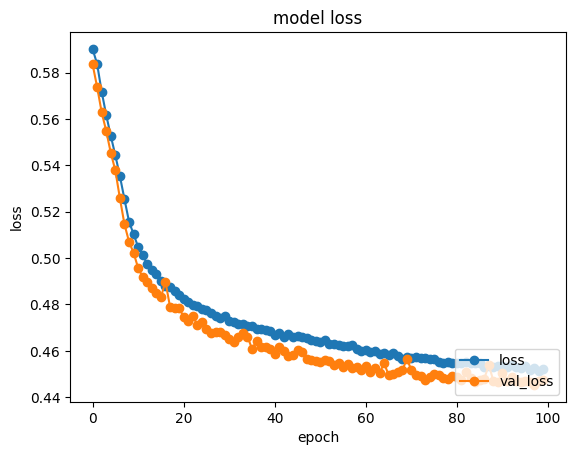

=== History 5 ===


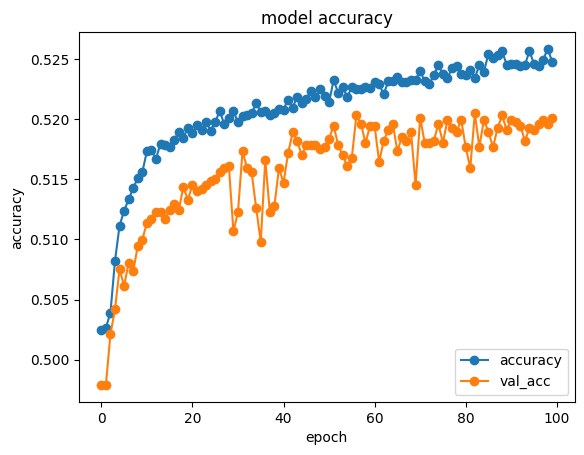

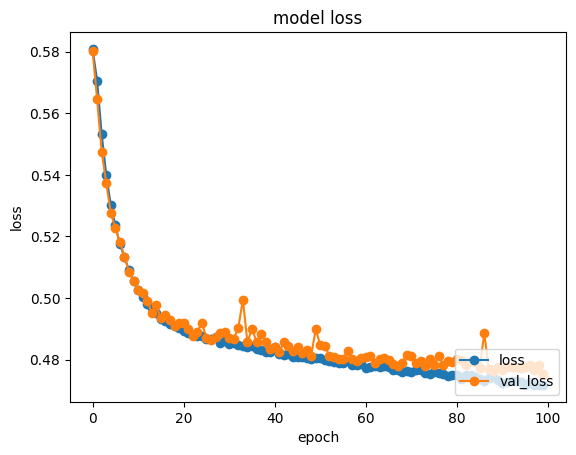

=== History 6 ===


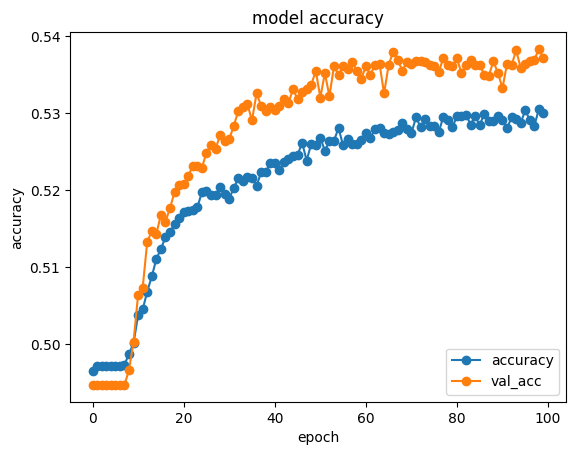

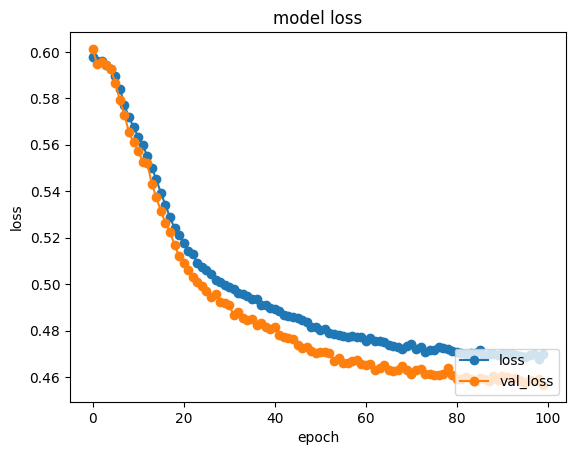

=== History 7 ===


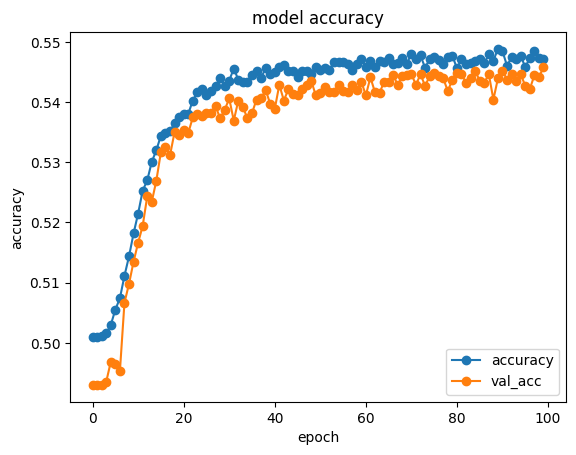

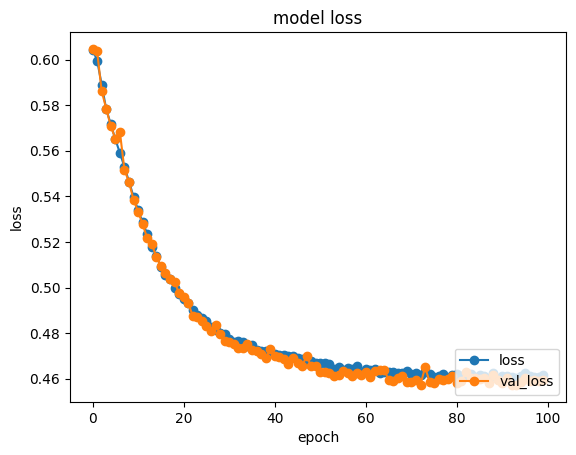

=== History 8 ===


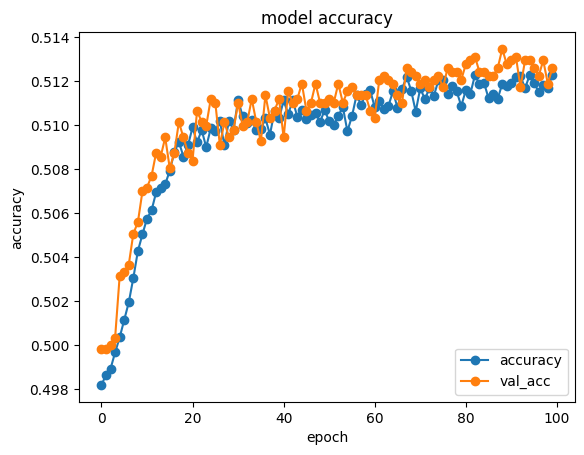

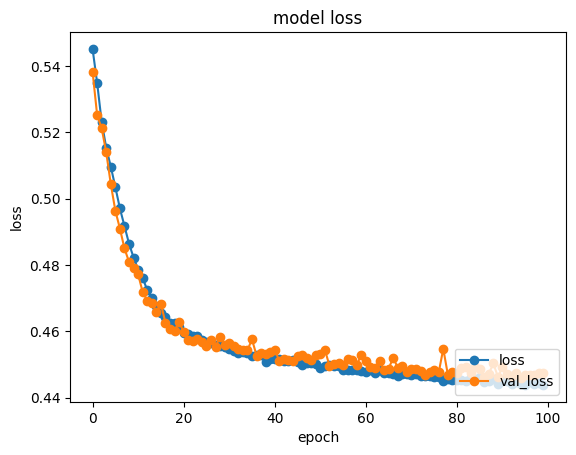

=== History 9 ===


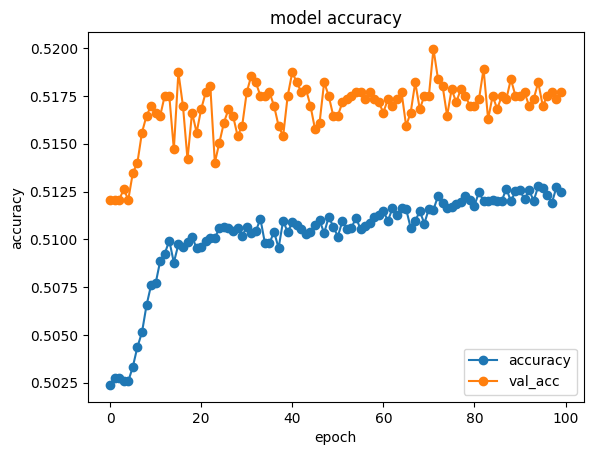

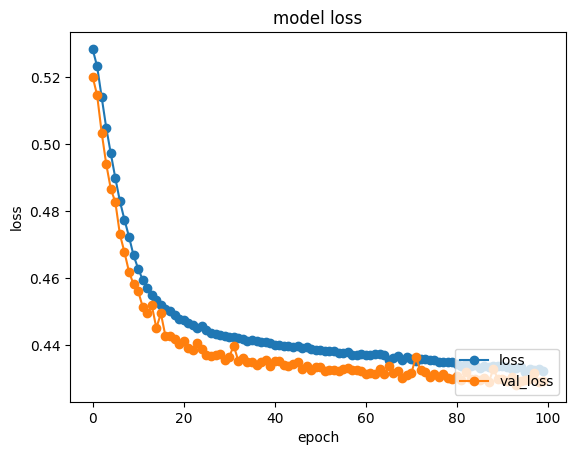

=== History 10 ===


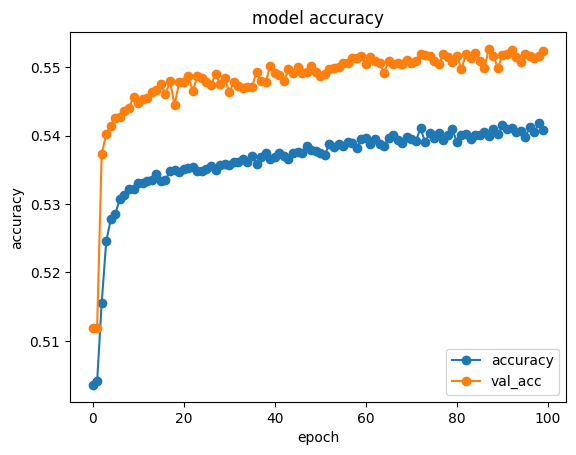

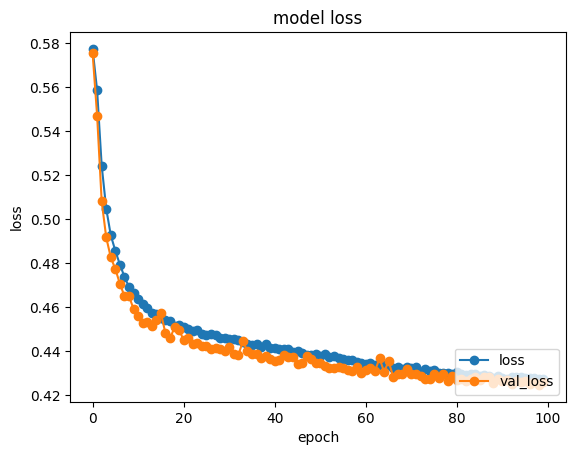

=== History 11 ===


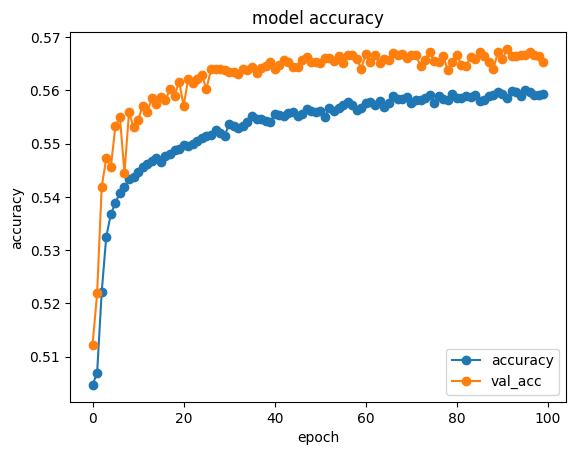

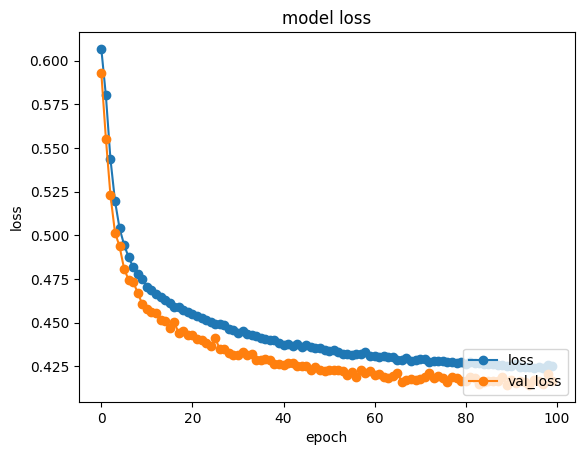

=== History 12 ===


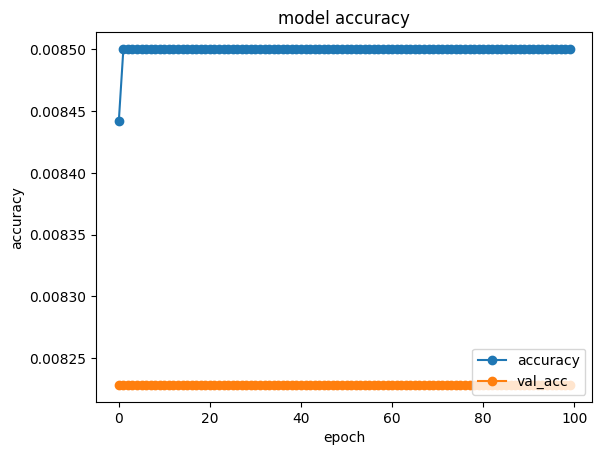

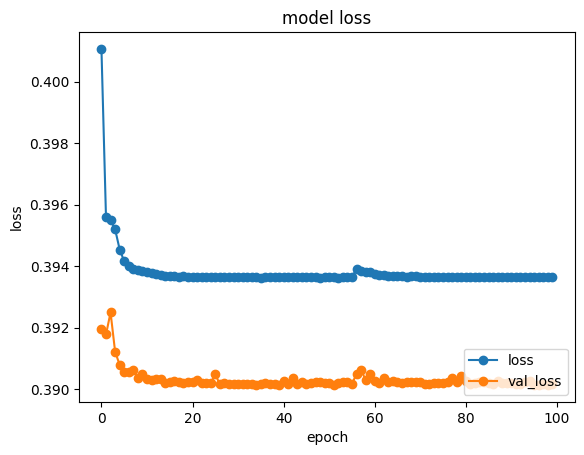

=== History 13 ===


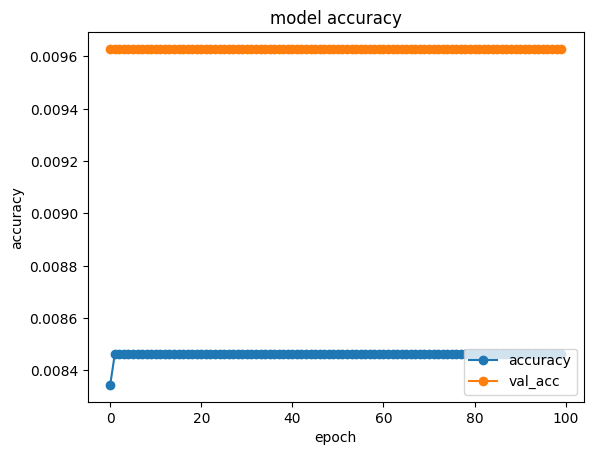

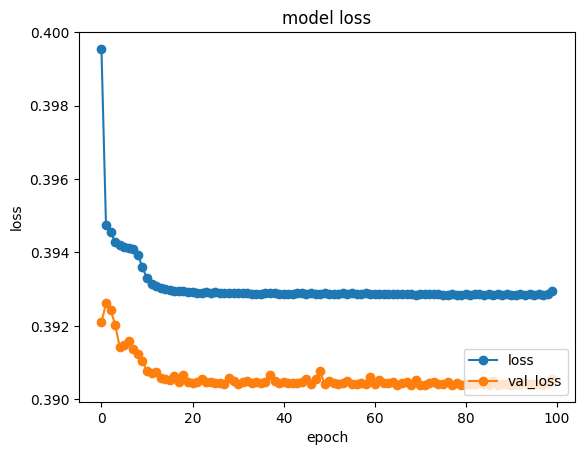

=== History 14 ===


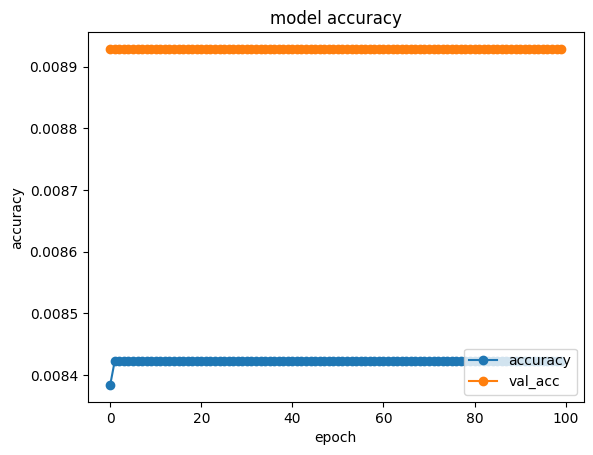

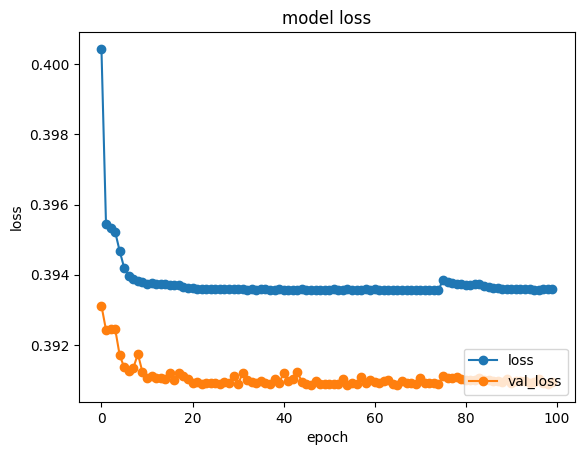

=== History 15 ===


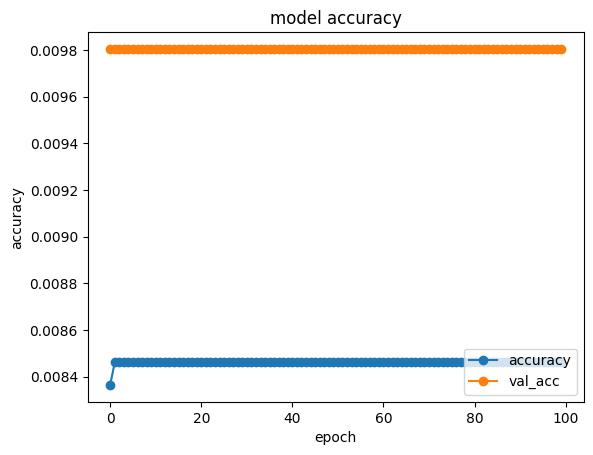

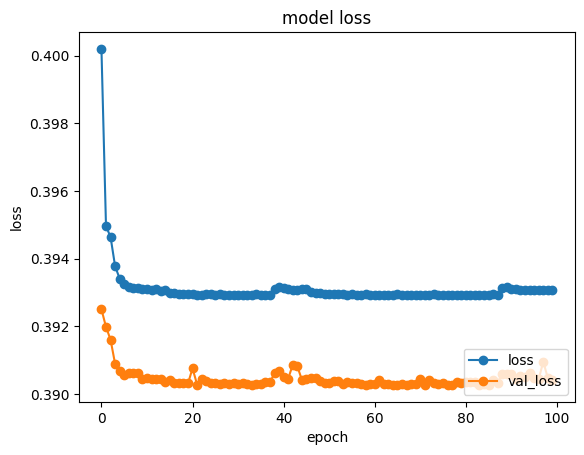

=== History 16 ===


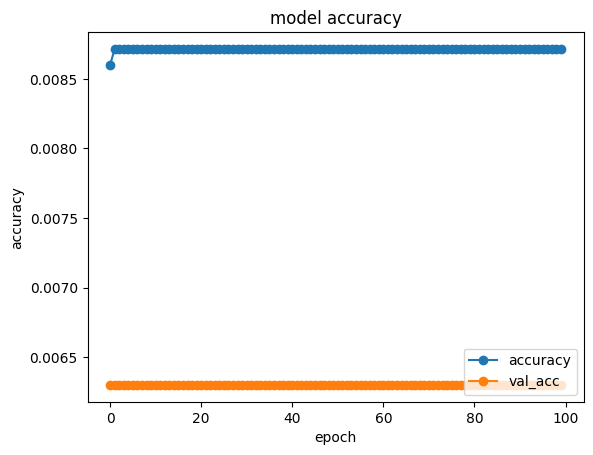

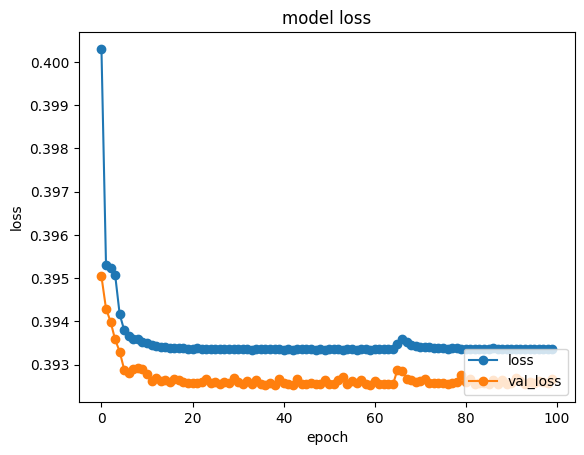

=== History 17 ===


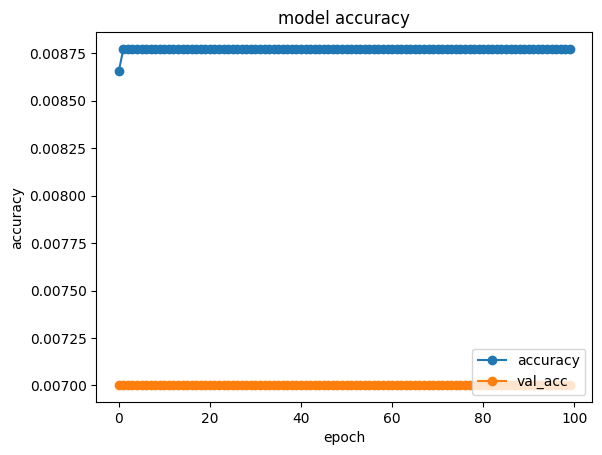

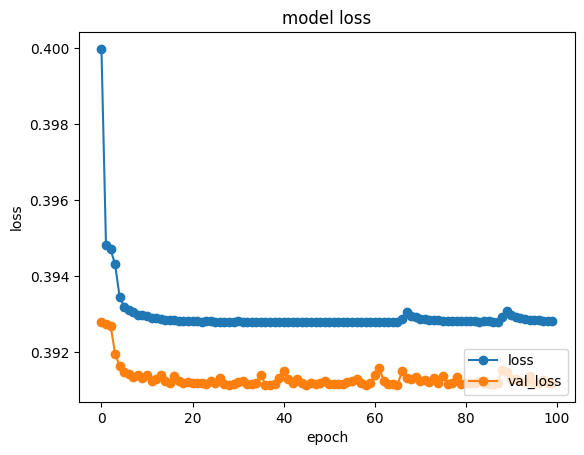

=== History 18 ===


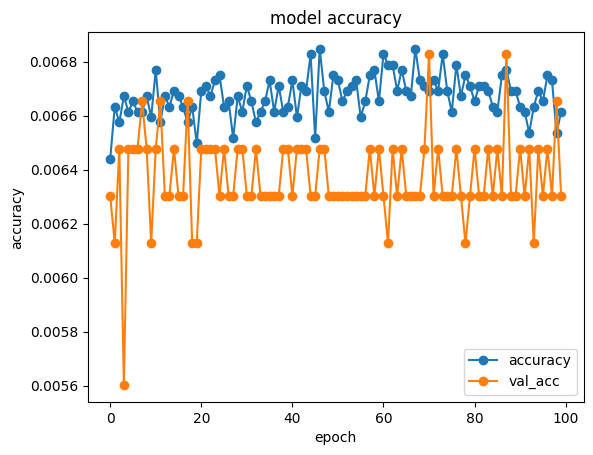

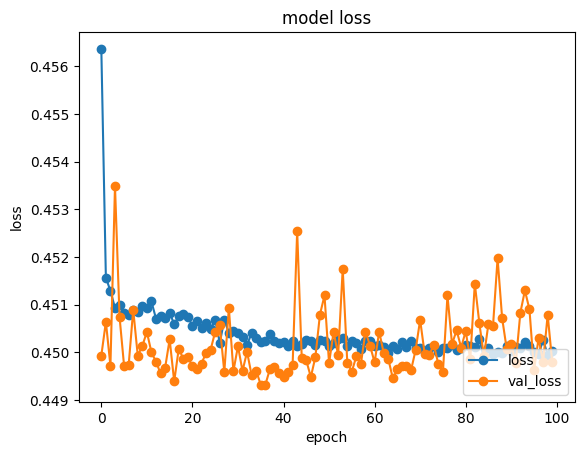

=== History 19 ===


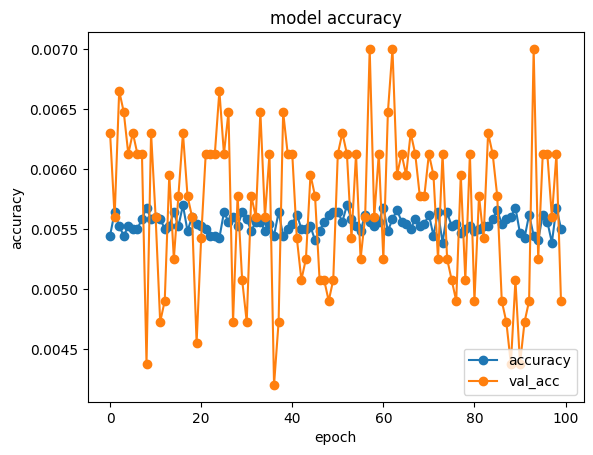

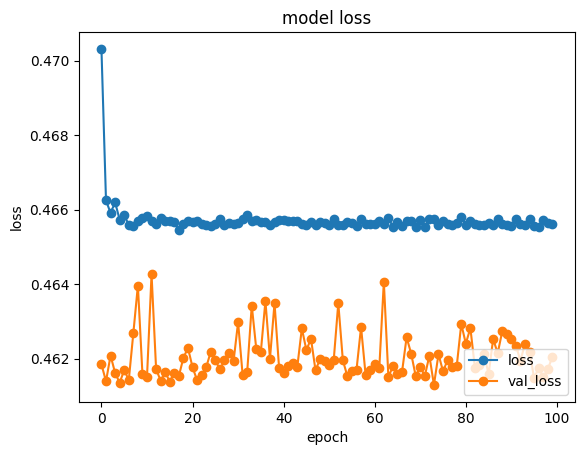

In [13]:
# loss 遷移のプロット

!pip install matplotlib

import matplotlib.pyplot as plt

for i in range(x.shape[2]):
    print("=== History " + str(i) + " ===")
    plot_history(histories[i])

In [14]:
# 楽曲の出力

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
import soundfile as sf

def add_fade(x, ft_len):
    r = np.arange(0, ft_len)*np.pi/ft_len
    w_fo = (0.5+0.5*np.cos(r))**0.5
    w_fi = (0.5-0.5*np.cos(r))**0.5
    
    x[0:ft_len]        *= w_fi
    x[clip_size-ft_len::] *= w_fo
    return x

def gen_xfade(x_pre, x_next, ft_len):
    if x_pre is None:
        xfade = x_next
    else:
        x_pre_begin = x_pre[:x_pre.shape[0] - ft_len]
        x_pre_end = x_pre[x_pre.shape[0] - ft_len:]
        x_pre_len = clip_size
        x_next_len = clip_size
        x_pre_len -= ft_len
        x_next_len -= ft_len
        xfade = np.concatenate((x_pre_begin, np.concatenate((x_pre_end, np.zeros(x_next_len))) + x_next))
    return xfade

def create_music_consider_weights(fname, rw):
    first_index = np.random.randint(0, len(cqt_chromas))
    predict_index = first_index
    out = None
    fade_samples = 10240
    
    for i in range(num_clips):
        print("-- generate " + str(i + 1) + " / " + str(num_clips))
        predict_vec = np.zeros((0, ))
        for i in range(x.shape[2]):
            predict = models[i].predict(np.array([cqt_chromas[predict_index, :-1]]))[0] * (y_maxs[i] - y_mins[i]) + y_mins[i]
            predict_vec = np.hstack((predict_vec, predict))
        predict_chroma = predict_vec[:len(predict_vec)-num_divide]
        predict_rhythm = predict_vec[len(predict_vec)-num_divide:]

        index = 0
        similar_index = 0
        score = -1 - rw
        chroma_score = 0
        rhythm_score = 0
        for cqt_chroma in cqt_chromas[:, (int)(fade_samples / hop_size)]:
            cqt_chroma_chroma = cqt_chroma[:len(cqt_chroma)-num_divide]
            cqt_chroma_rhythm = cqt_chroma[len(cqt_chroma)-num_divide:]
            tmp_chroma_score = cosine_similarity(np.array([predict_chroma]), np.array([cqt_chroma_chroma]))
            tmp_rhythm_score = cosine_similarity(np.array([predict_rhythm]), np.array([cqt_chroma_rhythm]))
            tmp_score = tmp_chroma_score + rw * tmp_rhythm_score
            if tmp_score > score:
                score = tmp_score
                similar_index = index
            index += 1

        print("score: " + str(score))
        print("predict_vec: " + str(predict_vec))
        print("cqt_chromas[similar_index]: " + str(cqt_chromas[similar_index, 0]))
        print("similar_index: " + str(similar_index))
        print("--")

        predict_index = similar_index

        tmp = add_fade(clips[predict_index], fade_samples)
        out = gen_xfade(out, tmp, fade_samples)
        
    sf.write(fname, out, SAMPLING_RATE, subtype="PCM_16")

models = []
for i in range(x.shape[2]):
    model_name = "independent_" + data_name + "_batch" + str(batch_size) + "_e" + str(epochs) + "_" + str(i)
    
    models.append(load_model("../data/models/" + model_name))

num_clips = 30
rhythm_weight = 0.5

for i in range(5):
    file_name = "out_" + "independent_" + data_name + "_batch" + str(batch_size) + "_e" + str(epochs) + "_rw" + format(rhythm_weight, '.2f').replace('.', '_')
    fname = "../data/out/" + file_name + "_track" + str(i) + ".wav"
    print("creating " + fname + " ...")
    create_music_consider_weights(fname, rhythm_weight)

creating ../data/out/out_independent_c81920_s20480_w10240_h640_d8_batch64_e100_rw0_1_track0.wav ...
-- generate 1 / 10
1/1 [==============================] - 0s 40ms/step
score: [[1.07156871]]
predict_vec: [0.00709631 0.0036616  0.00206888 0.003623   0.00109305 0.00019214
 0.00073949 0.00316736 0.00225818 0.00064699 0.00116747 0.00270888
 0.10557067 0.08809802 0.12501381 0.16089649 0.10917228 0.12328961
 0.13726692 0.13740768]
cqt_chromas[similar_index]: [0.0078125  0.00546229 0.0033575  0.00489353 0.         0.
 0.00169675 0.00352781 0.00293264 0.00187237 0.00270044 0.00416782
 0.5618593  0.5447889  0.47568232 0.6976695  0.9110087  0.38590908
 0.7263026  0.57266206]
similar_index: 46597
--
-- generate 2 / 10
1/1 [==============================] - 0s 19ms/step
score: [[1.05116539]]
predict_vec: [4.34890535e-04 1.75947195e-03 3.20182939e-04 8.83978268e-04
 4.05413052e-03 6.37507858e-03 9.64630628e-04 8.22043687e-04
 1.17484701e-03 4.36539203e-03 4.97041643e-03 5.38817141e-03
 4.83653367

1/1 [==============================] - 0s 17ms/step
score: [[1.04204996]]
predict_vec: [9.75244388e-04 1.75822165e-03 4.58826823e-03 1.08133303e-03
 1.12687412e-03 2.09733611e-03 6.44336222e-03 4.75992542e-03
 3.73940472e-03 5.15103689e-04 8.37162777e-04 3.41644580e-03
 2.57221818e-01 1.95432290e-01 2.06099272e-01 5.61371207e-01
 1.97575167e-01 2.00722069e-01 2.78173476e-01 2.68108428e-01]
cqt_chromas[similar_index]: [0.00161775 0.         0.00382689 0.         0.         0.
 0.0078125  0.00530902 0.00389478 0.         0.         0.00344604
 0.3223736  0.42368308 0.2888472  0.6308823  0.23402824 0.4028499
 0.27799487 0.20518401]
similar_index: 30734
--
-- generate 2 / 10
1/1 [==============================] - 0s 18ms/step
score: [[1.02529903]]
predict_vec: [1.78800628e-03 7.83755269e-04 2.80377665e-03 1.70466967e-03
 1.72083289e-03 4.37192805e-03 1.65437569e-03 1.31118926e-03
 3.17112915e-03 4.46837442e-03 1.47436385e-03 5.83193381e-04
 2.92857170e-01 6.31514490e-01 2.35333771e-01 3.98

1/1 [==============================] - 0s 21ms/step
score: [[1.06448528]]
predict_vec: [4.96536901e-04 1.25534181e-03 1.43579009e-03 1.24393369e-03
 1.37819443e-03 3.27858422e-03 6.33540039e-04 6.86315238e-04
 7.24057318e-04 2.49099033e-03 9.75063071e-04 1.94198044e-03
 4.98746037e-01 2.93900967e-01 5.41226029e-01 6.88561261e-01
 6.65527999e-01 5.52614450e-01 5.55160165e-01 4.97502714e-01]
cqt_chromas[similar_index]: [0.00160854 0.00220866 0.00421583 0.00387174 0.00276649 0.0078125
 0.         0.00218022 0.00429121 0.00665813 0.0028273  0.00430033
 0.6666188  0.42415994 0.49091473 0.29349095 0.53037935 0.6821062
 0.6640798  0.553155  ]
similar_index: 13055
--
-- generate 7 / 10
1/1 [==============================] - 0s 20ms/step
score: [[1.06448528]]
predict_vec: [4.96536901e-04 1.25534181e-03 1.43579009e-03 1.24393369e-03
 1.37819443e-03 3.27858422e-03 6.33540039e-04 6.86315238e-04
 7.24057318e-04 2.49099033e-03 9.75063071e-04 1.94198044e-03
 4.98746037e-01 2.93900967e-01 5.41226029e-

1/1 [==============================] - 0s 18ms/step
score: [[1.050598]]
predict_vec: [1.00173487e-03 1.30062620e-03 7.26926746e-03 5.62357996e-03
 1.62237836e-03 9.17486905e-04 9.59295197e-04 1.27160188e-03
 1.09339552e-03 9.22762789e-04 1.00040529e-03 2.95174279e-04
 6.53935671e-02 2.21495390e-01 1.83053061e-01 2.35868514e-01
 3.25355530e-01 1.72487110e-01 2.18079597e-01 2.11438119e-01]
cqt_chromas[similar_index]: [0.         0.         0.0078125  0.00704369 0.00378597 0.00104262
 0.         0.00178634 0.         0.00163353 0.         0.
 0.35482585 0.5397101  0.5009294  0.58109915 0.93186593 0.6421307
 0.6061151  0.6266234 ]
similar_index: 45539
--
-- generate 2 / 10
1/1 [==============================] - 0s 18ms/step
score: [[1.068254]]
predict_vec: [1.02396414e-03 6.26510358e-04 2.95513589e-03 4.27730801e-03
 6.20059203e-03 2.69820588e-03 4.71167790e-04 2.59294221e-03
 6.19547383e-04 3.63695231e-04 8.53541191e-04 1.55381754e-03
 5.09283245e-01 5.83869576e-01 9.22971845e-01 6.483425

1/1 [==============================] - 0s 19ms/step
score: [[1.06795545]]
predict_vec: [5.67990937e-04 3.08323448e-04 9.33335745e-04 6.66928943e-03
 1.73292623e-03 2.30742106e-03 3.07643693e-03 4.87778336e-04
 1.77730608e-03 8.77302489e-04 6.53547933e-04 6.59777550e-04
 4.83127806e-05 2.70819019e-05 1.12837828e-04 8.82424793e-05
 3.56509117e-05 3.25912806e-05 1.72467362e-02 3.10299937e-02]
cqt_chromas[similar_index]: [0.         0.         0.         0.0078125  0.00209186 0.00211006
 0.00296509 0.00122357 0.00152936 0.         0.         0.
 0.02198841 0.00613216 0.00372902 0.00176334 0.00081767 0.00046684
 0.3707802  0.39844573]
similar_index: 48185
--
-- generate 7 / 10
1/1 [==============================] - 0s 19ms/step
score: [[1.02296236]]
predict_vec: [2.66773440e-03 2.45869043e-03 1.94003806e-03 2.26650081e-05
 3.48207238e-03 3.48329078e-03 3.41975968e-03 3.35398875e-03
 1.85852905e-03 2.08692974e-03 2.39982316e-03 2.66863778e-03
 3.35389934e-03 1.65597466e-03 4.42516786e-04 3.0

1/1 [==============================] - 0s 16ms/step
score: [[1.06052415]]
predict_vec: [3.89972492e-03 6.11722982e-03 1.42428349e-03 1.66474158e-04
 5.71310660e-03 1.93663617e-03 1.68792543e-03 3.19907907e-04
 6.80830388e-04 7.49879226e-04 2.53107399e-03 7.02606793e-03
 1.94088548e-01 1.89964652e-01 2.54221082e-01 2.41063863e-01
 4.52425867e-01 3.61810982e-01 3.86094242e-01 3.51544201e-01]
cqt_chromas[similar_index]: [0.00454888 0.0068353  0.         0.         0.00617959 0.00364253
 0.00151132 0.         0.00113989 0.00081887 0.00556768 0.0078125
 0.04164499 0.04426319 0.01292962 0.02047673 0.0856341  0.04836026
 0.03926367 0.01425272]
similar_index: 16990
--
-- generate 2 / 10
1/1 [==============================] - 0s 16ms/step
score: [[1.06723051]]
predict_vec: [6.23649592e-03 5.59811620e-03 2.10079760e-03 1.40666438e-04
 8.60631626e-05 1.31170184e-03 2.78478931e-03 1.46888650e-03
 8.63468100e-04 8.84949754e-04 1.22148613e-03 5.25940617e-04
 1.20614814e-02 2.04344336e-02 8.44386071e

1/1 [==============================] - 0s 20ms/step
score: [[1.01237603]]
predict_vec: [0.0016281  0.00071098 0.00256118 0.0042925  0.00160987 0.00137118
 0.00216675 0.0013252  0.00121282 0.00060104 0.00057318 0.00100784
 0.0352979  0.09013651 0.05913048 0.12880138 0.1373163  0.47449562
 0.30015618 0.22318865]
cqt_chromas[similar_index]: [0.00266359 0.00234681 0.0068048  0.0078125  0.00123058 0.00272159
 0.00463238 0.00506367 0.         0.00311289 0.00283618 0.00176238
 0.1508761  0.18526131 0.21198538 0.19111264 0.19862951 0.2924338
 0.10055758 0.2724236 ]
similar_index: 57029
--
-- generate 7 / 10
1/1 [==============================] - 0s 17ms/step
score: [[1.05425316]]
predict_vec: [0.00132111 0.00031009 0.0004416  0.00072678 0.00155856 0.00417005
 0.00732403 0.0012069  0.00092948 0.00046906 0.00075963 0.00422976
 0.21430497 0.18993618 0.2040693  0.29162362 0.09498136 0.26593199
 0.28398174 0.24171676]
cqt_chromas[similar_index]: [0.00285347 0.         0.         0.         0.001690

1/1 [==============================] - 0s 17ms/step
score: [[1.04454644]]
predict_vec: [0.00190714 0.00764737 0.00466185 0.00264947 0.00056382 0.00113861
 0.00166528 0.00462841 0.00050927 0.00036032 0.00022982 0.00193631
 0.01171742 0.01258795 0.00944484 0.01996919 0.02043118 0.04281947
 0.06060378 0.06201209]
cqt_chromas[similar_index]: [0.00367228 0.00774977 0.0078125  0.0047585  0.         0.00105923
 0.0022263  0.00573146 0.         0.         0.         0.
 0.27520218 0.15802372 0.09638251 0.10758592 0.09372926 0.12967736
 0.33447558 0.46317893]
similar_index: 29453
--
-- generate 2 / 10
1/1 [==============================] - 0s 17ms/step
score: [[1.04654448]]
predict_vec: [0.00088292 0.00688528 0.00084788 0.00547778 0.0024631  0.00185251
 0.0010667  0.00075239 0.00241274 0.00067907 0.00067126 0.00474771
 0.09673516 0.10350152 0.09249902 0.12825796 0.33197001 0.45567676
 0.34811789 0.30540669]
cqt_chromas[similar_index]: [0.         0.0078125  0.         0.00642342 0.         0.00

1/1 [==============================] - 0s 16ms/step
score: [[1.06343403]]
predict_vec: [0.00131993 0.00159006 0.00512518 0.0072388  0.00438779 0.00468104
 0.00227429 0.00107842 0.00123702 0.00078183 0.00044813 0.00067814
 0.27749705 0.4317944  0.10003406 0.20591107 0.09344996 0.17337583
 0.17596707 0.18566251]
cqt_chromas[similar_index]: [0.         0.         0.0071651  0.0078125  0.00520719 0.00547243
 0.00276546 0.         0.         0.         0.         0.
 0.27271038 0.4320671  0.09914964 0.20787455 0.09821016 0.17656513
 0.13961972 0.15270713]
similar_index: 13620
--
-- generate 2 / 10
1/1 [==============================] - 0s 16ms/step
score: [[1.05234247]]
predict_vec: [1.70264015e-04 4.18435317e-03 3.82641447e-04 3.98439262e-03
 3.38976108e-03 1.46770093e-03 1.66324188e-03 3.35752848e-04
 7.46197416e-04 1.12656842e-03 5.07940771e-03 1.78583537e-03
 1.01080820e-01 2.05709010e-01 9.80278552e-02 1.78907350e-01
 1.34314179e-01 1.52223095e-01 1.75090402e-01 1.79269508e-01]
cqt_chr

1/1 [==============================] - 0s 19ms/step
score: [[1.03538417]]
predict_vec: [0.00120275 0.00193577 0.00070972 0.00554417 0.0024714  0.00078289
 0.00025785 0.00134582 0.00079291 0.00503721 0.00081148 0.00384247
 0.09237733 0.12963811 0.19678855 0.15068804 0.07476678 0.11413159
 0.1490757  0.13081758]
cqt_chromas[similar_index]: [0.00166465 0.0026706  0.00438009 0.00777907 0.00677528 0.
 0.         0.         0.         0.0078125  0.00120488 0.00555623
 0.38697147 0.62589884 0.70959854 0.76824415 0.41008765 0.58576113
 0.75460994 0.8707997 ]
similar_index: 51304
--
-- generate 7 / 10
1/1 [==============================] - 0s 18ms/step
score: [[1.03628775]]
predict_vec: [3.07288778e-04 2.43738934e-04 1.68448617e-03 2.44135247e-03
 9.09523922e-04 4.55871224e-03 3.28498689e-04 1.04441424e-03
 5.82957466e-04 4.71800799e-03 1.11907173e-03 5.08522557e-04
 7.16590106e-01 7.50207722e-01 4.14425880e-01 5.91661751e-01
 7.38960028e-01 8.75278533e-01 6.63639963e-01 5.99110782e-01]
cqt_chr

1/1 [==============================] - 0s 17ms/step
score: [[1.06348343]]
predict_vec: [0.00568745 0.00647166 0.00574795 0.00035366 0.0007523  0.00107814
 0.00078294 0.00035801 0.0019921  0.00315279 0.00291535 0.00157526
 0.06315652 0.05446394 0.14102453 0.10377129 0.08388445 0.08030093
 0.09814867 0.09818503]
cqt_chromas[similar_index]: [0.00655921 0.0078125  0.00646612 0.         0.         0.
 0.         0.         0.         0.00339203 0.00219137 0.00213759
 0.39640644 0.84850365 0.55538154 0.68558884 0.76803017 0.7517495
 0.54790175 0.6805948 ]
similar_index: 24123
--
-- generate 2 / 10
1/1 [==============================] - 0s 17ms/step
score: [[1.04935391]]
predict_vec: [1.67938089e-03 3.38441948e-03 2.81238277e-03 3.38215451e-03
 2.04150798e-04 4.05704835e-04 1.14894100e-03 2.14546616e-03
 5.30514866e-03 1.01702299e-03 6.36768853e-03 5.60687529e-03
 5.67696512e-01 6.80989087e-01 7.64522552e-01 7.48317063e-01
 5.51431239e-01 6.74691796e-01 5.93159020e-01 5.48608303e-01]
cqt_chro

1/1 [==============================] - 0s 17ms/step
score: [[1.05630733]]
predict_vec: [3.82447266e-04 5.64153213e-03 5.76470839e-03 2.22274824e-03
 7.15683331e-04 6.98230462e-04 6.41970895e-04 3.67418933e-03
 1.56917493e-03 5.14039246e-04 2.76926858e-03 8.16377753e-04
 3.20586354e-01 2.02736333e-01 2.29005054e-01 1.86131343e-01
 2.40938872e-01 4.23576713e-01 3.55608106e-01 3.38179618e-01]
cqt_chromas[similar_index]: [0.         0.0078125  0.00605976 0.00319193 0.         0.
 0.         0.00324444 0.00186279 0.00211284 0.00230541 0.
 0.02496068 0.01827711 0.01706831 0.00927629 0.05544783 0.06992577
 0.06618434 0.08180214]
similar_index: 44122
--
-- generate 2 / 10
1/1 [==============================] - 0s 19ms/step
score: [[1.05821015]]
predict_vec: [0.00183257 0.00526597 0.00022565 0.0012998  0.00091934 0.00088269
 0.00725135 0.00415109 0.00119356 0.0009107  0.00188597 0.00212501
 0.01616462 0.00951122 0.05745244 0.06931152 0.06502375 0.08016582
 0.10158353 0.0955418 ]
cqt_chromas[sim

1/1 [==============================] - 0s 18ms/step
score: [[1.04095695]]
predict_vec: [1.96817960e-03 1.27982127e-03 2.55440455e-03 2.17219465e-03
 3.58551112e-03 2.56404909e-03 1.17249181e-03 4.35580121e-04
 3.57164466e-03 4.52676369e-03 3.84528510e-04 6.73180853e-04
 1.69959515e-01 3.40696096e-01 2.04043999e-01 3.23233455e-01
 2.25136563e-01 4.46552157e-01 3.48361611e-01 3.30719799e-01]
cqt_chromas[similar_index]: [0.00429352 0.         0.0036221  0.00278455 0.00740102 0.00624786
 0.         0.         0.00745814 0.0078125  0.         0.00371922
 0.63968754 0.35825163 0.7668004  0.32091975 0.35275653 0.5183139
 0.6310763  0.38031793]
similar_index: 17294
--
-- generate 2 / 10
1/1 [==============================] - 0s 17ms/step
score: [[1.06637359]]
predict_vec: [3.00392718e-03 5.38523134e-04 6.28856011e-04 8.41985282e-04
 6.16385485e-04 7.48055289e-04 2.11167149e-03 3.49711184e-03
 3.40122287e-03 1.46616308e-03 7.53056258e-04 2.46542110e-03
 7.61808872e-01 3.22594911e-01 3.54064912e

1/1 [==============================] - 0s 18ms/step
score: [[1.05679703]]
predict_vec: [2.80540972e-03 6.64210820e-04 5.37204370e-03 3.85500630e-03
 9.58529126e-04 1.03600312e-03 1.65476766e-03 7.43195473e-04
 2.20082374e-03 2.57783663e-03 1.27559830e-03 5.86325245e-04
 8.67908120e-01 5.18996418e-01 7.32596934e-01 4.12769645e-01
 9.01100636e-01 5.11504352e-01 5.32555163e-01 5.41285396e-01]
cqt_chromas[similar_index]: [0.0047355  0.00193895 0.0078125  0.00753855 0.         0.00193012
 0.00395312 0.         0.00316578 0.00350915 0.00447514 0.00228037
 0.47181737 0.42614982 0.48809633 0.40618837 0.6069707  0.19178027
 0.4087208  0.48745692]
similar_index: 23185
--
-- generate 7 / 10
1/1 [==============================] - 0s 18ms/step
score: [[1.0622882]]
predict_vec: [8.43027257e-04 1.77751761e-03 4.52481396e-03 6.79091259e-04
 2.22474686e-03 3.52670136e-03 3.98319354e-03 5.33521641e-04
 4.92178602e-04 3.73717165e-03 5.42206736e-03 4.62953281e-03
 4.94865626e-01 4.05454397e-01 6.20517373e

KeyboardInterrupt: 